
### Prepare the datasets and models
1.  In this practice, we are going to use the word2vec functioanlity from GloVe. 
Therefore, you need to download the `glove.840B.300d.txt` from here:
    - Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download): [glove.840B.300d.zip](https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip) [[mirror](https://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip)]
    Once you downloaded the zip file, extract the `glove.840B.300d.txt` into the `data/` folder.
1.  The dataset that we are going to train our models on is [Text Document Classification Dataset](https://www.kaggle.com/datasets/sunilthite/text-document-classification-dataset?resource=download) from kaggle.
    - Download the datset, which gives you a zip file `df_file.csv.zip`
    - Extract this zip file and add the `df_file.csv` file to the `data/` folder.

Now your `data` folder should looks like this:  
📦data  
 ┣ 📜df_file.csv  
 ┗ 📜glove.840B.300d.txt  

 

In [103]:
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd
import tensorflow as tf
import random as rn
import itertools
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer #The package name is Keras-Preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,  ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from my_models import *


In [104]:
def mk_dir(folder_path):
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

root_data_path = 'data'
mk_dir(root_data_path)
embeding_folder_path = os.path.join(root_data_path, 'original_embedding')
mk_dir(embeding_folder_path)
my_embeding_folder_path = os.path.join(root_data_path, 'my_embedding')
mk_dir(my_embeding_folder_path)

embedding_labels_path = os.path.join(embeding_folder_path,'embedding_labels.csv')
original_embedding_file_location = os.path.join(root_data_path,'glove.840B.300d.txt')
data_path = os.path.join(root_data_path,'df_file.csv')

root_model_path = os.path.join(root_data_path, 'models')
mk_dir(root_model_path)

csv_log_training_root = os.path.join(root_model_path, 'csv_log_training')
mk_dir(csv_log_training_root)

error_training_root = os.path.join(root_model_path, 'error_training')
mk_dir(error_training_root)
submission_training_root = os.path.join(root_model_path, 'error_training')
mk_dir(submission_training_root)


In [105]:
# Custom Modelling Options #######################
remove_stops = False
do_lemmatize = False
do_stemming = False
nbr_folds = 3
nbr_epochs = 25

embedding_to_use = 'glove' #Takes 'glove' or 'w2v' or 'dv'

modeling = 'lstm' #Takes 'lstm' or 'rnn' or 'gru'or 'stacked_lstm' or 'stacked_gru', or 'bidirectional_lstm', or 'cnn_unigram', 'cnn_bigram', 'cnn_unibigram'

dataset_to_use = 'final' 

################################################################

In [106]:
########Data Directories and File Names
nbr_words = 200000
nbr_seq = 80
embedding_dim = 300

my_embedding_file = os.path.join(my_embeding_folder_path, 'embedding_matrix_' + embedding_to_use + '.npy')
stamp = dataset_to_use + '_' + embedding_to_use + '_' + modeling
bst_model_path = os.path.join(root_model_path, 'model_' + stamp)

In [ ]:
# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(150)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(150)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.random.set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.random.set_seed(150)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


In [108]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False, lemmatize_words = False):
    text = re.sub(r"[^A-Za-z0-9]", " ", text)

    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]

    text = " ".join(text)

    # Clean the text
    if lemmatize_words:
        text = text.split()
        lemm = WordNetLemmatizer()
        text = [lemm.lemmatize(word) for word in text]
        #stemmed_words = [s.encode('UTF-8', 'strict') for s in string]
        text = " ".join(text)
        #print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    # Return a list of words
    return (text)


In [109]:
def my_randomEmbeddings(word_indices, EMBEDDING_DIM, divident = 1.0):
    n = len(word_indices) + 1
    m = EMBEDDING_DIM
    emb = np.empty((n, m), dtype=np.float32)
    emb[:,:] = np.random.normal(size=(n,m)) / divident
    emb[0, :] = np.zeros((1,m), dtype="float32")
    return (emb)

def my_embeddings(word_indices, GLOVE_FILE, emb):
    with open(GLOVE_FILE, encoding='utf-8') as f:
        for i, line in enumerate(f):
            s = line.split()
            if s[0] in word_indices:
                try:
                    emb[word_indices[s[0]], :] = np.asarray(s[1:])
                except ValueError:
                    #print(s[0])
                    continue
    return (emb)

In [110]:
print('Processing text dataset')
X = []
y = []
X_test = []
y_test = []

with codecs.open(data_path, encoding='utf-8') as f:
    reader = csv.reader(f)#, delimiter='\t')
    header = next(reader)
    for values in reader:
        X.append(text_to_wordlist(values[0],remove_stopwords=remove_stops,
                                     stem_words=do_stemming, lemmatize_words = do_lemmatize ))

        y.append(values[1])
print('Found %s texts in data file' % len(X))



tokenizer = Tokenizer(num_words=nbr_words)
tokenizer.fit_on_texts(X)

seq = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

padded_data = pad_sequences(seq, maxlen=nbr_seq, padding='pre', truncating='pre')
padded_data = np.array(padded_data)
y_train = np.array(y)
nb_words = min(nbr_words, len(word_index)) +1

new_df = pd.DataFrame(columns=['word','index'])
new_df.loc[0] = ['UNK', 0]
embedding_labels = pd.DataFrame(list(word_index.items()),columns=['word', 'index'])
# new_df = new_df.append(embedding_labels)
new_df = pd.concat([new_df, embedding_labels], ignore_index=True)
new_df.to_csv(embedding_labels_path, sep = '\t', index=False)


print('Shape of training data tensor:', padded_data.shape)
print('Shape of label tensor:', y_train.shape)

########################################
## prepare embeddings
########################################
if os.path.exists(my_embedding_file):
   embedding_matrix = np.load(open(my_embedding_file, 'rb'))
else: 
    print('Preparing embedding matrix')
    embedding_matrix = my_randomEmbeddings(word_index, embedding_dim)
    embedding_matrix = my_embeddings(word_index, original_embedding_file_location, embedding_matrix)
    np.save(open(my_embedding_file, 'wb'), embedding_matrix)


print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Processing text dataset
Found 2225 texts in data file
Found 29457 unique tokens
Shape of training data tensor: (2225, 80)
Shape of label tensor: (2225,)
Null word embeddings: 1


In [111]:
# comment them again after you get w2v.txt and glove.txt files,so that it does not save over and over again

df_1 = pd.DataFrame()
df_1['word'] = new_df['word']
df_2 = pd.DataFrame(embedding_matrix)
print(len(df_1))

embeding_1_file_path = os.path.join(embeding_folder_path, '1.txt')
embeding_2_file_path = os.path.join(embeding_folder_path, '2.txt')
df_1.to_csv(embeding_1_file_path, sep=' ', index=False, encoding='utf-8')
df_2.to_csv(embeding_2_file_path, sep=' ', index=False, encoding='utf-8')

df_1 = pd.read_csv(embeding_1_file_path, sep=' ')
df_2 = pd.read_csv(embeding_2_file_path, sep=' ')

df = pd.concat([df_1,df_2], axis=1, ignore_index=True)

##### change the filename, if it is needed as w2v.txt
embeding_file_path = os.path.join(embeding_folder_path, 'glove.txt')
df.to_csv(embeding_file_path, sep=' ', index=False, encoding='utf-8')

29458


In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_stuff(y_test, y_pred, class_names):
    print('\n============= PLOTTING CONFUSION MATRIX ==============\n')
    # plot confusion matrix without normalization
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #class_names = pd.read_csv("data/labels.csv")
    #class_names = class_names['target_label'].values
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

    plt.show()
    print('\n================== PLOTTING CLASSIFICATION SUMMARY =================== \n')
    print(classification_report(y_test, y_pred, target_names = class_names))

In [ ]:
le = LabelEncoder()
le.fit(y)
LabelEncoder()
class_names = (list(le.classes_))

nbr_classes = len(class_names)

y_kfold = le.transform(y)

kfold = StratifiedKFold(n_splits=nbr_folds, shuffle=True, random_state=42)
i = 1
for train, test in kfold.split(padded_data, y_kfold):
    if modeling=='lstm':
        model = my_lstm(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='rnn':
        model = my_rnn(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='gru':
        model = my_gru(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='stacked_lstm':
        model = my_stacked_lstm(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='stacked_gru':
        model = my_stacked_gru(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='bidirectional_lstm':
        model = my_bidirectional_lstm(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='cnn_unigram':
        model = my_cnn_unigram(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='cnn_bigram':
        model = my_cnn_bigram(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

    elif modeling=='cnn_unibigram':
        model = my_cnn_unibigram(nb_words, embedding_matrix, embedding_dim, nbr_seq, nbr_classes)

  # create model
    train_data = padded_data[train]
    y_train = y_kfold[train]
    y_train = to_categorical(y_train)

    test_data = padded_data[test]
    y_test = y_kfold[test]
    y_test = to_categorical(y_test)
    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])

    bst_weights_path=bst_model_path + "_fold_"+str(i)+".weights.h5"
    i=i+1
    if os.path.exists(bst_weights_path):
        continue
    else: 
        ########################################
        ## train the model
        ########################################
        csv_log_training_path = os.path.join(csv_log_training_root, stamp + '_trainingLog.csv')
        logCallback = CSVLogger(csv_log_training_path, separator=',', append=True)
        model_checkpoint = ModelCheckpoint(bst_weights_path, monitor='val_acc', save_best_only=True, save_weights_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=1, min_lr=0.000001, verbose=1)
        hist = model.fit(train_data, y_train,
                         validation_data=(test_data, y_test),
                         epochs=nbr_epochs,
                         batch_size=32,
                         shuffle=True,
                         verbose=1,
                         #class_weight=class_weight,
                         callbacks=[model_checkpoint, logCallback, reduce_lr])        
        

### Evaluate models trained on every fold to get final k-fold cross validation accuracy.

  saveable.load_own_variables(weights_store.get(inner_path))


PLOT STUFF FOR FOLD:  1
2/2 - 0s - 169ms/step
Accuracy: : 92.59%

============= PLOTTING CONFUSION MATRIX ==============

Confusion matrix, without normalization
Normalized confusion matrix


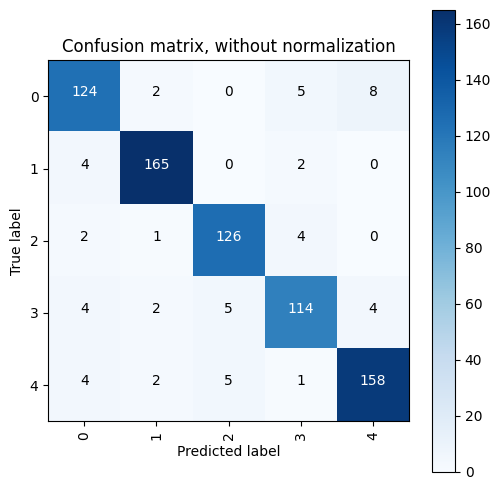

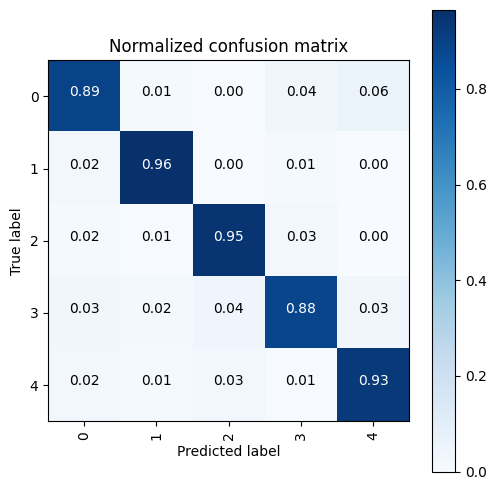


================== PLOTTING CLASSIFICATION SUMMARY =================== 

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       139
           1       0.96      0.96      0.96       171
           2       0.93      0.95      0.94       133
           3       0.90      0.88      0.89       129
           4       0.93      0.93      0.93       170

    accuracy                           0.93       742
   macro avg       0.92      0.92      0.92       742
weighted avg       0.93      0.93      0.93       742



  saveable.load_own_variables(weights_store.get(inner_path))


PLOT STUFF FOR FOLD:  2
2/2 - 0s - 189ms/step
Accuracy: : 92.05%

============= PLOTTING CONFUSION MATRIX ==============

Confusion matrix, without normalization
Normalized confusion matrix


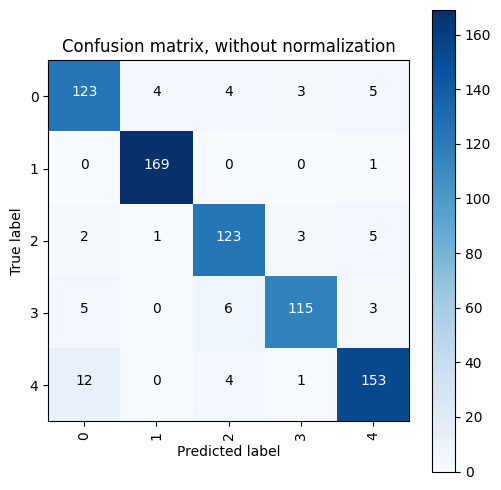

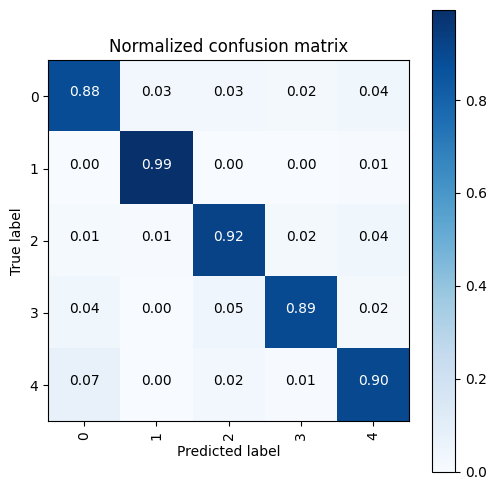


================== PLOTTING CLASSIFICATION SUMMARY =================== 

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       139
           1       0.97      0.99      0.98       170
           2       0.90      0.92      0.91       134
           3       0.94      0.89      0.92       129
           4       0.92      0.90      0.91       170

    accuracy                           0.92       742
   macro avg       0.92      0.92      0.92       742
weighted avg       0.92      0.92      0.92       742

PLOT STUFF FOR FOLD:  3


  saveable.load_own_variables(weights_store.get(inner_path))


2/2 - 0s - 161ms/step
Accuracy: : 92.04%

============= PLOTTING CONFUSION MATRIX ==============

Confusion matrix, without normalization
Normalized confusion matrix


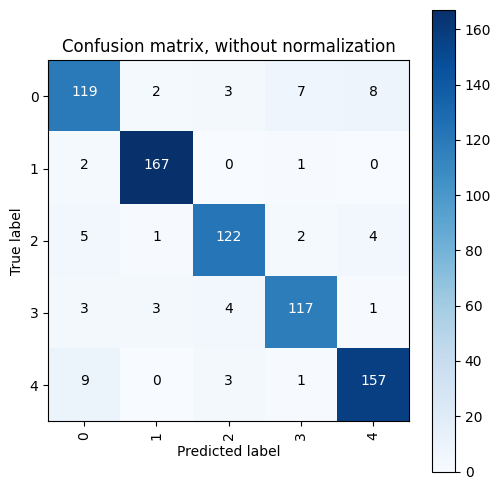

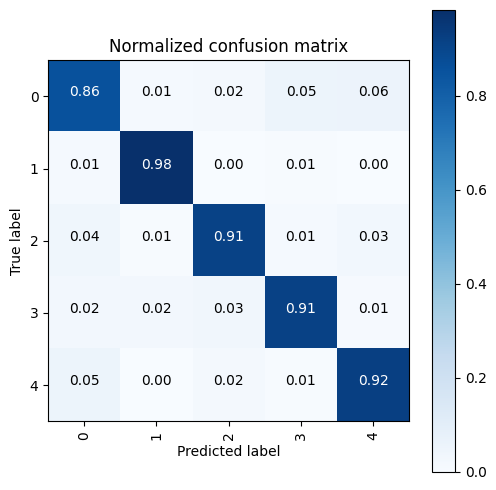


================== PLOTTING CLASSIFICATION SUMMARY =================== 

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       139
           1       0.97      0.98      0.97       170
           2       0.92      0.91      0.92       134
           3       0.91      0.91      0.91       128
           4       0.92      0.92      0.92       170

    accuracy                           0.92       741
   macro avg       0.92      0.92      0.92       741
weighted avg       0.92      0.92      0.92       741

Accuracy of 10-Fold Cross Validation with standard deviation: 

92.22% (+/- 0.26%)
Model Used:  lstm
Embedding Used:  glove


In [114]:
i = 1
cvscores = []

for train, test in kfold.split(padded_data, y_kfold):
  # create model
    #model = model_1((64, 64, 1), 22)

    test_data = padded_data[test]
    y_test = y_kfold[test]
    y_test_enc = to_categorical(y_test)
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
    
    bst_weights_path=bst_model_path + "_fold_"+str(i)+".weights.h5"
    
    model.load_weights(bst_weights_path)



    print ('PLOT STUFF FOR FOLD: ', i)
    #scores = model.evaluate(test_data, y_test, verbose=0)
    

    
    pred_prob = model.predict(test_data, batch_size=384, verbose=2)
    pred_prob = np.array(pred_prob)
    
   # pred_prob[pred_prob >= 0.5] = 1
   # pred_prob[pred_prob < 0.5] = 0
    pred_label = np.argmax(pred_prob, axis = 1)
    scores = accuracy_score(y_test, pred_label)
    print("%s: %.2f%%" % ('Accuracy: ', scores*100))
    cvscores.append(scores * 100)
    #summary = classification_report(y_test, pred_label, target_names = class_names)
    plot_stuff(y_test, pred_label, class_names)
    i = i+1
    if i == 2:
        actual_labels = le.inverse_transform(y_test)
        predicted_labels = le.inverse_transform(pred_label)
        
        submission = pd.DataFrame()
        a = np.array(X)

        submission['post'] = a[test]
        submission['actual_label'] = actual_labels
        submission['predicted_label'] = predicted_labels
        #submission.to_csv(stamp + '_submission.csv', sep = '\t', index=False, encoding = 'utf-8')
        
        df2 = submission.loc[submission['actual_label'] != submission['predicted_label']]
        error_training_path = os.path.join(error_training_root, stamp + '_errors.csv')
        df2.to_csv(error_training_path, sep = '\t', index=False, encoding = 'utf-8')
        probability_class = pred_prob.max(axis=1)
        submission['probability'] = probability_class
        submission_training_path = os.path.join(submission_training_root, stamp + '_submission.csv')
        submission.to_csv(submission_training_path, sep = '\t', index=False, encoding = 'utf-8')
    #print(summary)
print ("====================================================")
print("Accuracy of 10-Fold Cross Validation with standard deviation: \n")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Model Used: ", modeling)
print("Embedding Used: ", embedding_to_use)


In [115]:
len(probability_class)

742